Laplace Smoothing: 0.1 <> Naive Bayes Accuracy: 98.2 %
Laplace Smoothing: 0.5 <> Naive Bayes Accuracy: 97.08 %
Laplace Smoothing: 1.0 <> Naive Bayes Accuracy: 96.4 %
Laplace Smoothing: 10 <> Naive Bayes Accuracy: 47.42 %
Laplace Smoothing: 100 <> Naive Bayes Accuracy: 46.97 %


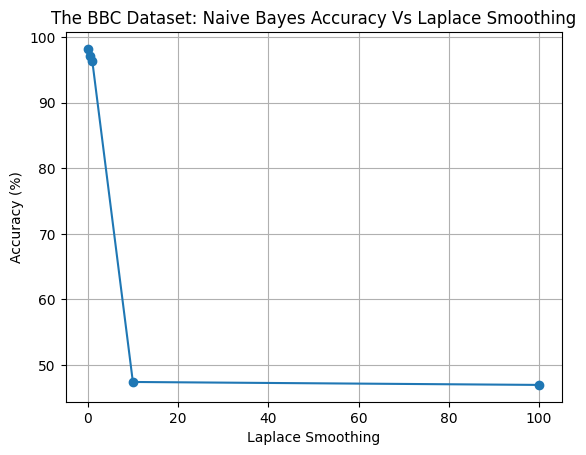

In [3]:
import math
import random
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import time
import numpy as np
from cmath import exp, pi, sqrt
from naive_bayes import NaiveBayes


def accuracy_score(true_labels, pred_labels):

    correct = 0
    for true, pred in zip(true_labels, pred_labels):
        if true == pred:
            correct += 1

    return (correct / len(true_labels))*100

def train_test_split(data, test_ratio=0.2):
    random.shuffle(data)
    test_size = int(len(data) * test_ratio)
    return data[test_size:], data[:test_size]




'''
feature extraction 1:

The frequency of all terms for each class in the training data.

Just like the occurence of 'free' might determine the if an email is spam or ham, we
can as well assume that the relatively higher number of occurence of some terms in a document might
help us determine its class.
'''
# ________________________________________________________________________
doc_class = {}

filename = 'bbc\\bbc.classes'
with open(filename, 'r') as file:
    for ind, line in enumerate(file):        
        if ind > 3:
            doc, _class = map(int, line.split())
            doc_class[doc + 1] = _class

matrix = defaultdict(lambda: defaultdict(float))
filename = 'bbc\\bbc.mtx'

unique_words = defaultdict(int)


with open(filename, 'r') as file:
    for ind, line in enumerate(file):
        
        line = line.strip()
        if ind > 1 and line:
            word, doc, freq = line.split()
            matrix[int(doc)][int(word)] = float(freq)
            unique_words[word] += 1
            



datasets = []
for doc, words in matrix.items():
    dataset = [0]*9636
    for word, freq in words.items():
        dataset[word - 1] = freq
    
    dataset[-1] = doc_class[doc]
    datasets.append(dataset)


"""
the following block uses extraction method 1 and tests the Naive Bayes algorithm
"""
train, test = train_test_split(datasets)

train_features = [x[:-1] for x in train]
train_labels = [x[-1] for x in train]
test_features = [x[:-1] for x in test]
test_labels = [x[-1] for x in test]

laplace_smoothings =  [0.1, 0.5, 1.0, 10, 100]
accuracy_result = []

for smoothing in laplace_smoothings:

    naive_bayes = NaiveBayes(laplace_smoothing=smoothing, total_data=len(train_labels))
    naive_bayes.train(train_features, train_labels)
    naive_bayes_predictions = naive_bayes.test(test_features)
    naive_bayes_accuracy = accuracy_score(test_labels, naive_bayes_predictions)
    print(f"Laplace Smoothing: {smoothing}", "<> Naive Bayes Accuracy:", round(naive_bayes_accuracy, 2), '%')
    accuracy_result.append(round(naive_bayes_accuracy, 2))


plt.plot(laplace_smoothings, accuracy_result, marker='o')
plt.xlabel('Laplace Smoothing')
plt.ylabel('Accuracy (%)')
plt.title('The BBC Dataset: Naive Bayes Accuracy Vs Laplace Smoothing')
plt.grid(True)
plt.show()





Learning Rate: 0.0001 Accuracy: 94.38
Learning Rate: 0.001 Accuracy: 94.38
Learning Rate: 0.01 Accuracy: 94.38
Learning Rate: 0.1 Accuracy: 96.85
Learning Rate: 1.0 Accuracy: 98.43
Learning Rate: 1.5 Accuracy: 98.43


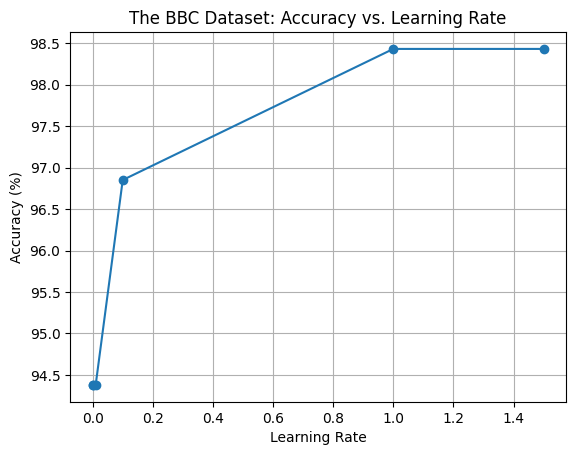

In [1]:
import math
import random
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import time
import numpy as np
from cmath import exp, pi, sqrt
from logistic_regression import LogisticRegression




def train_test_split(data, test_ratio=0.2):
    random.shuffle(data)
    test_size = int(len(data) * test_ratio)
    return data[test_size:], data[:test_size]


def open_file(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    return [line.strip() for line in lines]


def accuracy_score(true_labels, pred_labels):

    correct = 0
    for true, pred in zip(true_labels, pred_labels):
        if true == pred:
            correct += 1

    return round((correct / len(true_labels))*100, 2)



def feature_extraction_2():
    
    '''
    Term Frequency-Inverse Document Frequency (TF-IDF):

    We were recommended by many online sources as a feature
    extraction method for Logistic Regression. 

    The goal of TF-IDF is to represent each document
    as a vector of features that capture the most 
    important words or terms in the document.
    '''

    label = {}
    for line in open_file('bbc/bbc.classes')[4:]:
        doc, _class = line.split()
        label[int(doc)] = int(_class)


    word_doc_freq = open_file('bbc/bbc.mtx')[2:]

    # preprocess for vectorization
    # _________________________________________________________________________
    document_length = defaultdict(int)
    for line in word_doc_freq:
        word_no, doc, freq = [int(float(x)) for x in line.split()]
        document_length[doc] += freq
    
    
    word_count = defaultdict(lambda: defaultdict(int))
    for line in word_doc_freq:
        word_no, doc, freq = [int(float(x)) for x in line.split()]
        word_count[word_no][doc] += freq



    term_frequency = defaultdict(lambda: defaultdict(int))
    for word, text in word_count.items():
        for doc, count in text.items():
            term_frequency[word][doc] = count / document_length[doc]

    inverse_doc_freq = defaultdict(int)
    for word, text in word_count.items():
        inverse_doc_freq[word] = math.log(len(document_length) / len(text))
    

    
    # vectorize
    # _________________________________________________________________________
    num_terms, num_docs = 9635, 2226
    vector = {doc:[0 for i in range(num_terms)] for doc in range(1, num_docs)}
    for word, text in term_frequency.items():
        for doc, freq in text.items():
            vector[doc][word - 1] = freq * inverse_doc_freq[word]
    

    # prepare dataset
    # _____________________________________________________________________________
    dataset = []
    for doc, text in vector.items():
        dataset.append((label[doc - 1], text))
    
    # split dataset into training and test data
    trainining_set, test_set = train_test_split(dataset)

    # split features and labels
    train_feature, train_labels , test_features, test_labels = [], [], [], []
    for data in trainining_set:
        train_feature.append(data[1])
        train_labels.append(data[0])
    
    for data in test_set:
        test_features.append(data[1])
        test_labels.append(data[0])

    return train_feature, train_labels , test_features, test_labels

   







train_feature, train_labels , test_features, test_labels = feature_extraction_2()
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]
accuracy = []


for rate in learning_rates:

    logistic_regression = LogisticRegression(num_classes=5, learning_rate=rate)
    logistic_regression.train(np.array(train_feature), np.array(train_labels))

    logistic_regression_predictions = logistic_regression.test(test_features)
    logistic_regression_accuracy = accuracy_score(test_labels, logistic_regression_predictions)
    accuracy.append(logistic_regression_accuracy)
    print(f'Learning Rate: {rate}', f'Accuracy: {logistic_regression_accuracy}')

plt.plot(learning_rates, accuracy, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.title('The BBC Dataset: Accuracy vs. Learning Rate')
plt.grid(True)
plt.show()



Laplace Smoothing: 0.1 <> Naive Bayes Accuracy: 96.85 %
Laplace Smoothing: 0.5 <> Naive Bayes Accuracy: 97.08 %
Laplace Smoothing: 1.0 <> Naive Bayes Accuracy: 96.63 %
Laplace Smoothing: 10 <> Naive Bayes Accuracy: 66.29 %
Laplace Smoothing: 100 <> Naive Bayes Accuracy: 45.62 %


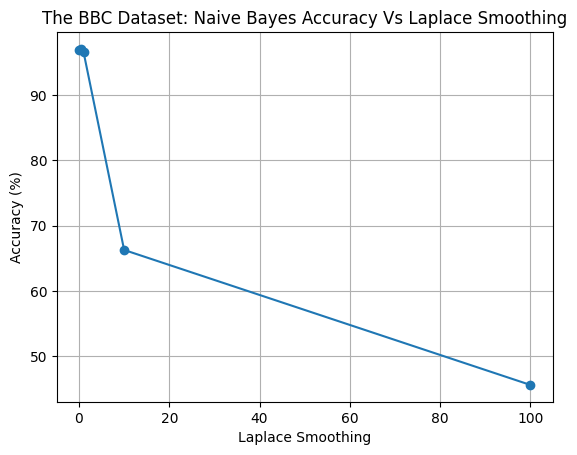

In [2]:
"""
Feature Extraction 3
"""


import math
import random
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from naive_bayes import NaiveBayes

def accuracy_score(true_labels, pred_labels):

    correct = 0
    for true, pred in zip(true_labels, pred_labels):
        if true == pred:
            correct += 1

    return round((correct / len(true_labels))*100, 2)

def train_test_split(data, test_ratio=0.2):
    random.shuffle(data)
    test_size = int(len(data) * test_ratio)
    return data[test_size:], data[:test_size]


"""
feature extraction 3

Instead of taking the frequency of terms, the 3rd method considers only if a term exists or
not (0 or 1)

This idea came up as a what if, no specific reason.
There's only a single change to feature extraction 1 to for this method

"""
doc_class = {}

filename = 'bbc\\bbc.classes'
with open(filename, 'r') as file:
    for ind, line in enumerate(file):        
        if ind > 3:
            doc, _class = map(int, line.split())
            doc_class[doc + 1] = _class

matrix = defaultdict(lambda: defaultdict(float))
filename = 'bbc\\bbc.mtx'

unique_words = defaultdict(int)


with open(filename, 'r') as file:
    for ind, line in enumerate(file):
        
        line = line.strip()
        if ind > 1 and line:
            word, doc, freq = line.split()

            """
            instead of taking the frequency we only set it to 1 because we've seen it
            otherwise it is 0 by default since we're using defaultdict .
            """
            matrix[int(doc)][int(word)] = 1
            unique_words[word] += 1
            



datasets = []
for doc, words in matrix.items():
    dataset = [0]*9636
    for word, freq in words.items():
        dataset[word - 1] = freq
    
    dataset[-1] = doc_class[doc]
    datasets.append(dataset)



train, test = train_test_split(datasets)

train_features = [x[:-1] for x in train]
train_labels = [x[-1] for x in train]
test_features = [x[:-1] for x in test]
test_labels = [x[-1] for x in test]


laplace_smoothings =  [0.1, 0.5, 1.0, 10, 100]
accuracy_result = []

for smoothing in laplace_smoothings:

    naive_bayes = NaiveBayes(laplace_smoothing=smoothing, total_data=len(train_labels))
    naive_bayes.train(train_features, train_labels)
    naive_bayes_predictions = naive_bayes.test(test_features)
    naive_bayes_accuracy = accuracy_score(test_labels, naive_bayes_predictions)
    print(f"Laplace Smoothing: {smoothing}", "<> Naive Bayes Accuracy:", naive_bayes_accuracy, '%')
    accuracy_result.append(naive_bayes_accuracy)



plt.plot(laplace_smoothings, accuracy_result, marker='o')
plt.xlabel('Laplace Smoothing')
plt.ylabel('Accuracy (%)')
plt.title('The BBC Dataset: Naive Bayes Accuracy Vs Laplace Smoothing')
plt.grid(True)
plt.show()



